In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from operator import itemgetter

In [2]:
plt.rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

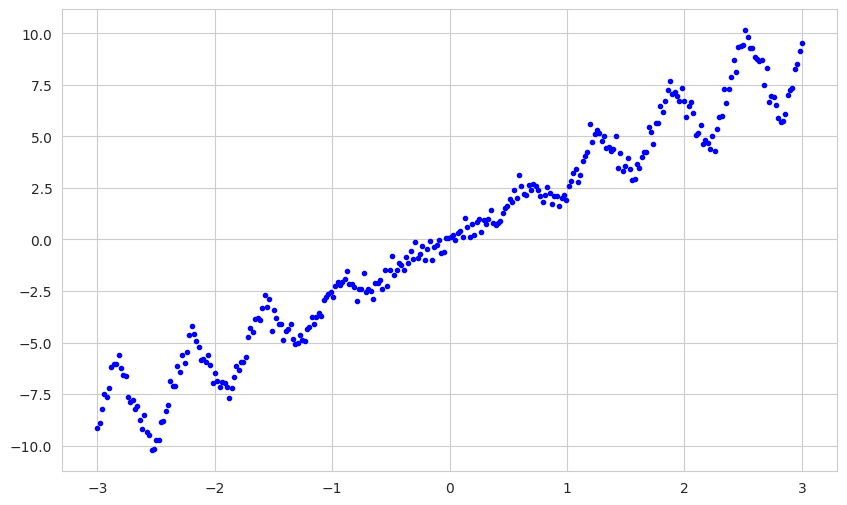

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

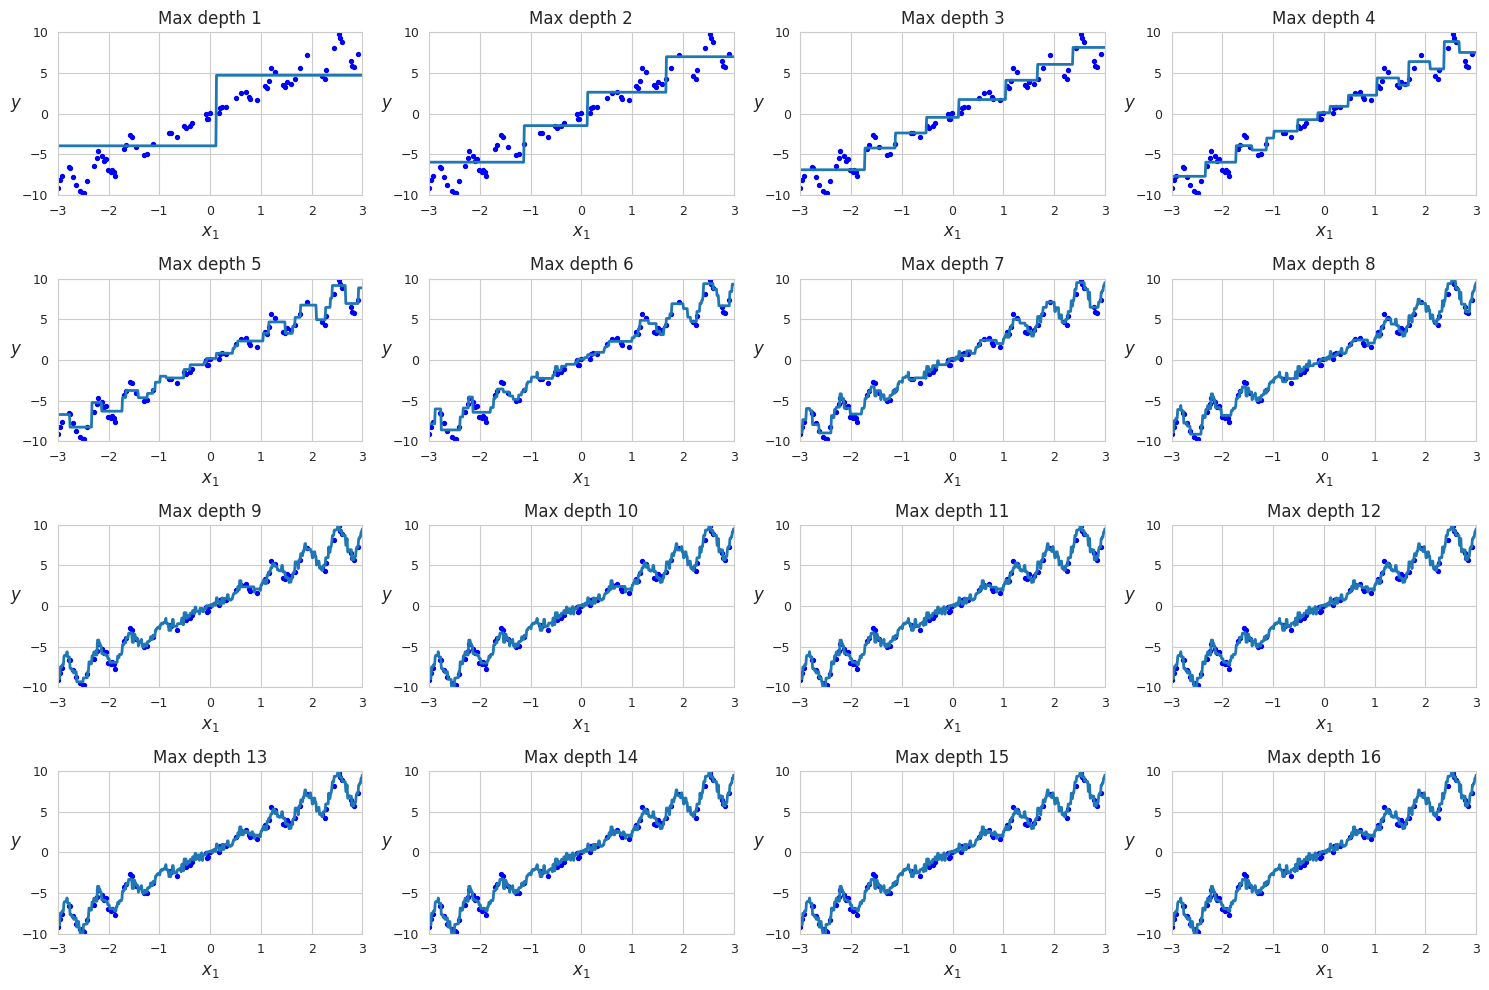

In [6]:
plt.figure(figsize=(15, 10))

for i in range(1, 17):
    tree_reg = DecisionTreeRegressor(max_depth=i, random_state=SEED)
    tree_reg.fit(X_train, y_train)
    plt.subplot(4, 4, i)
    plot_regression_predictions(tree_reg, X_test, y_test)
    plt.scatter(X_test, y_test, color='b', linewidth=1, s=8)
    plt.tick_params(axis='both', which='major', labelsize=9)

    plt.title(f'Max depth {i}')

plt.tight_layout()
plt.show();

> Мой коммент

Модель явно переобучается на шум примерно при глубине 7-8, дальше уже визуально изменений не заметно.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
def ens_prob_prediction_fix_param(model_prob=0.65, models_number=101):
    prob = 0
    for i in range((models_number + 1) // 2, models_number + 1):
        prob += math.comb(models_number, i) * (model_prob ** i) * (1 - model_prob) ** (models_number - i)
    return prob

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

> **Мой коммент**

Функцию написал под оба случая, графики вместе отрисовал. Кажется, хорошо получилось.

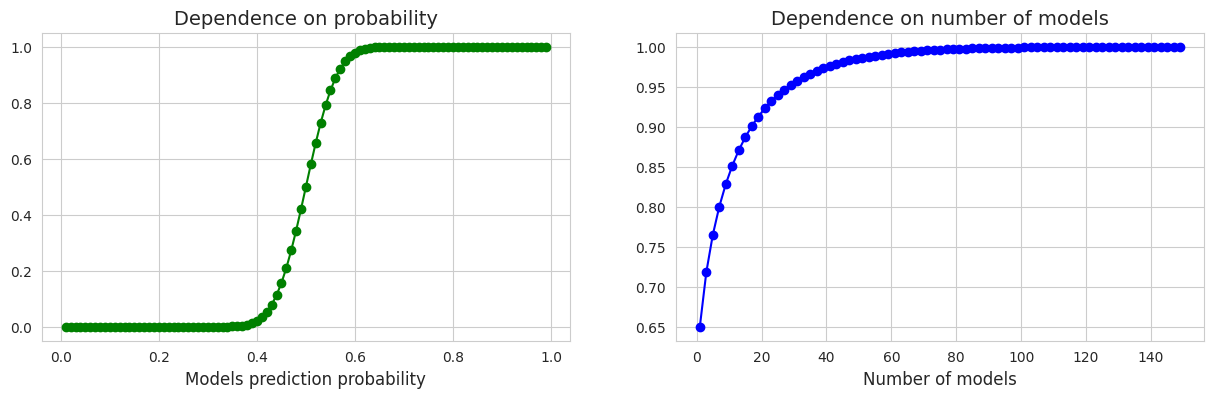

In [8]:
model_probs = np.arange(0.01, 1, 0.01)
models_n = np.arange(1, 150, 2)

probs_on_probs = [ens_prob_prediction_fix_param(model_prob=prob) for prob in model_probs]
probs_on_models_n = [ens_prob_prediction_fix_param(models_number=num) for num in models_n]

figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 4)) 

axis[0].plot(model_probs, probs_on_probs, marker='o', linestyle='-', color='g')
axis[0].set_title('Dependence on probability', fontsize = 14)
axis[0].set_xlabel('Models prediction probability', fontsize = 12)
axis[1].plot(models_n, probs_on_models_n, marker='o', linestyle='-', color='b')
axis[1].set_title('Dependence on number of models', fontsize = 14)
axis[1].set_xlabel('Number of models', fontsize = 12)

plt.subplots_adjust(hspace=0.3)

plt.show();

Опишите ваши наблюдения:

* при вероятности <0.5 итоговое пресказание хуже, чем для одной модели.
* после 0.5 - начинает экспоненциально расти и приближается к 1 уже при индивидиальной вероятности ок. 0.7.
* при увеличении моделей с фиксированной вероятностью предсказания быстро улучшаются, и после определённого числа моделей наступает "насыщение"
* значит, используя подобный подход, мы можем получать предсказния с точностью, намного выше точности отделной модели
* число моделей для такого подхода не имеет смысла всё время увеличивать, нужно подбирать некий оптимум, после котрого рост точности уже пренебрежимо мал

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [12]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
            self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        # Обнуляем список. Кажется, что для изменяемого типа данных это логично,
        # чтобы не накапливалось деревьев, если вдруг запустят фит несколько раз подряд
        self.trees = []
        features_number = X.shape[1]

        features_number = X.shape[1]
        
        # max_features для ленивых или забывших указать его
        if self.max_features is None:
            if features_number < 3:
                # для 1-2 признаков ставим 1
                max_features = 1
            elif features_number < 6:
                # До 8 признаков - по два
                max_features = 2
            else:
                # Для большего числа - треть
                max_features = features_number // 3
        else:
            if self.max_features > features_number:
                raise ValueError('Parametr max_features is greater than dataset features number')
            max_features = self.max_features
        
        for i in range(self.n_estimators):
            #  Меняем сид
            np.random.seed(SEED + i)

            # Случайно отбираем из индексов X фиксированное число признаков
            current_features_idxs = np.random.choice(features_number, max_features, replace=False)
            self.feat_ids_by_tree.append(current_features_idxs)

            # Бутстреп данных
            #  Определяем индексы образцов, половина с повторами, и отбираем их
            bootstrap_idxs = np.random.choice(X.shape[0], X.shape[0] // 2, replace=True)
            X_bootstrap = np.take(X, bootstrap_idxs, axis=0)
            #  По этим же индексам отбираем тренировочные лейблы
            y_bootstrap = np.take(y, bootstrap_idxs, axis=0)
            #  Теперь оставляем только выбранные признаки
            X_bootstrap = np.take(X_bootstrap, current_features_idxs, axis=1)

            # Все данные готовы для модели
            dt_cl = DecisionTreeClassifier(max_depth=self.max_depth, random_state=SEED)
            dt_cl.fit(X_bootstrap, y_bootstrap)

            #  Сохраняем обученную модель
            self.trees.append(dt_cl)

        return self

    def predict_proba(self, X):
        # Создаём список для хранения предсказаний
        pred_prob = []

        for i in range(self.n_estimators):
            # Отбираем из данных только нужные признаки
            X_feature_sample = np.take(X, self.feat_ids_by_tree[i], axis=1)

            # Делаем предсказания вероятностей
            current_pred_proba = self.trees[i].predict_proba(X_feature_sample)
            pred_prob.append(current_pred_proba)

        # Считаем среднее
        mean_pred = np.sum(np.array(pred_prob), axis=0) / self.n_estimators

        return mean_pred

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [13]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=12)
    plt.ylabel(r"$x_2$", fontsize=12, rotation=0)

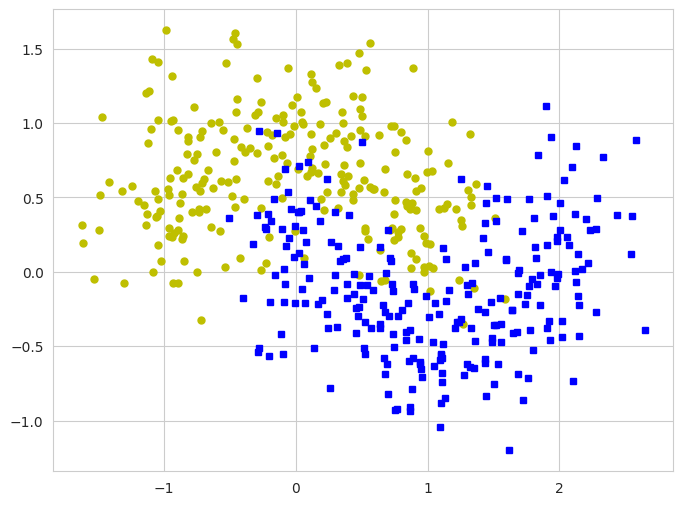

In [14]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.rcParams.update({'lines.markersize': 5})

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

> Мой коммент

Сначала проверим, что получилось

In [16]:
my_tree = RandomForestClassifierCustom(n_estimators=25, max_depth=10, max_features=2)
my_tree.fit(X_train, y_train)

RandomForestClassifierCustom(max_depth=10, max_features=2, n_estimators=25)

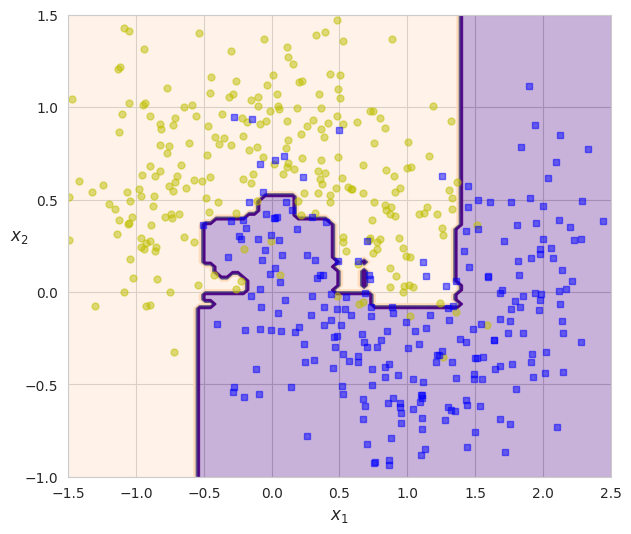

In [17]:
plt.figure(figsize=(7, 6))
plot_decision_boundary(my_tree, X, y)

> Мой коммент

Видно, что есть небольшое переобучение, но это уже не сравнить с переобучением отдельного дерева большой глубины, ансамбль работает намного лучше.

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

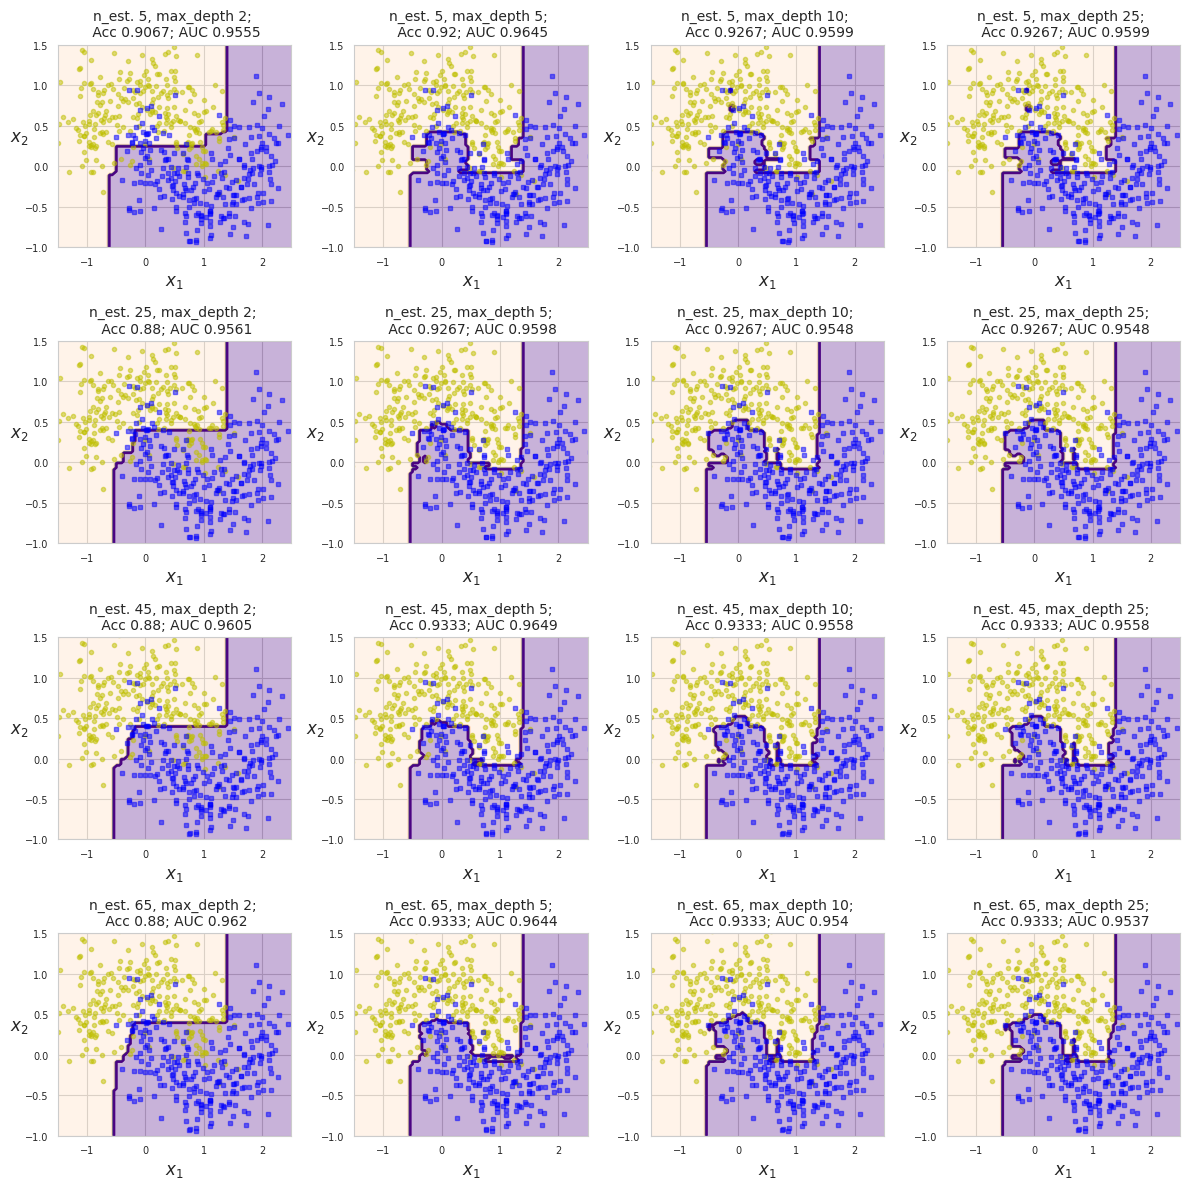

In [18]:
plt.rcParams.update({'lines.markersize': 3})
plt.figure(figsize=(12, 12))

max_depths_list = [2, 5, 10, 25]

for i in range(0, 16):
    n_est = 5 + 20 * (i // 4)
    max_dp=max_depths_list[i % 4]
    my_tree = RandomForestClassifierCustom(n_estimators=n_est, max_depth=max_dp, max_features=2)
    my_tree.fit(X_train, y_train)
    y_pred = my_tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_proba = my_tree.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.subplot(4, 4, i+1)
    plot_decision_boundary(my_tree, X, y)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.title(f'n_est. {n_est}, max_depth {max_dp}; \n Acc {acc:.4g}; AUC {auc:.4g}', fontsize=10)

plt.tight_layout()
plt.show();

> Мой коммент

Для "игрушечного" набора метрики меняются не слишком заметно. Видно, что две метрики могут меняться в разные строны, что говорит о необходимости их внимательного выбора в зависимоти от задач. Для маленькой глубины увеличение числа деревьев ухудшило точность. А для 5 эстиматоров на большой глубене заметны переобученные точки.

Интересно, что по выбранным метрикам и проверенным параметрам лучшее сочетание достигнуто для 45 деревьев с глубиной 5. в целом, данные не такие сложные, чтобы была необходимость в очень глубоких деревьях. И очевидно, что нет смысла постоянно увеличивать количество эстиматоров, поскольку с какого-то момента это уже не даёт прироста качества модели.

Ещё интересно получается для варианта с отбором одного признака, когда их всего два: переобучение очень заметно, а метрики хуже. Очевидно, что подход RSM лучше будет работать для достаточно большого числа признаков.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [19]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [20]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
X.shape

(569, 30)

In [22]:
corr_list = []

max_features_list = [1, 2, 3, 5, 10, 15, 20, 25]

for i in max_features_list:
    rf_cl = RandomForestClassifier(n_estimators=20, max_features=i, random_state=SEED)
    rf_cl.fit(X_train, y_train)
    models_corrs = base_model_pair_correlation(rf_cl, X_test)
    corr_list.append(models_corrs)

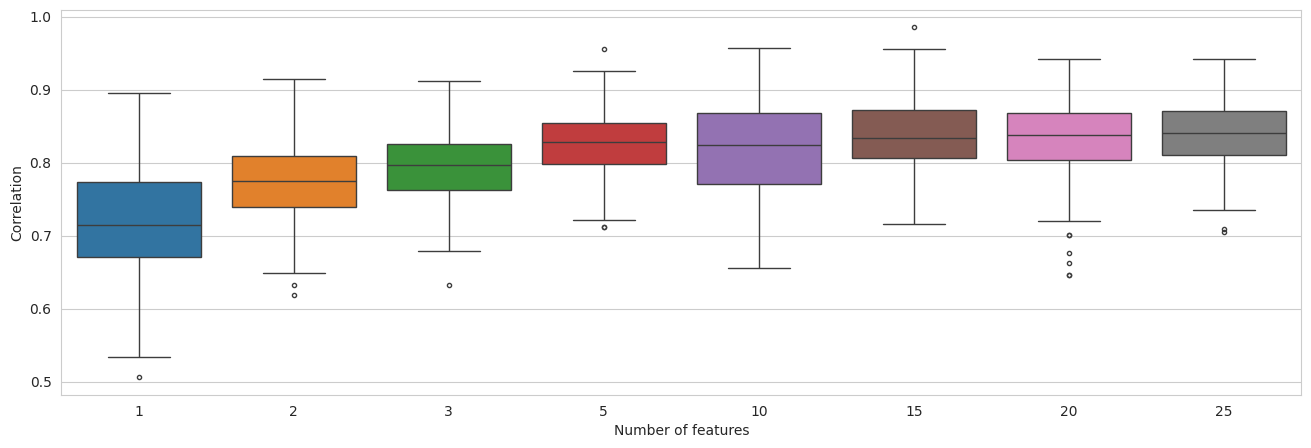

In [23]:
plt.figure(figsize=(16,5))
plt.axes(xlabel = 'Number of features', ylabel = 'Correlation', xticklabels = max_features_list)

sns.boxplot(data=corr_list);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [24]:
corr_max_depth_list = []

max_depth_list = [1, 2, 3, 5, 7, 10, 15, 30]

for i in max_depth_list:
    rf_cl = RandomForestClassifier(n_estimators=20, max_depth=i, random_state=SEED)
    rf_cl.fit(X_train, y_train)
    models_corrs = base_model_pair_correlation(rf_cl, X_test)
    corr_max_depth_list.append(models_corrs)

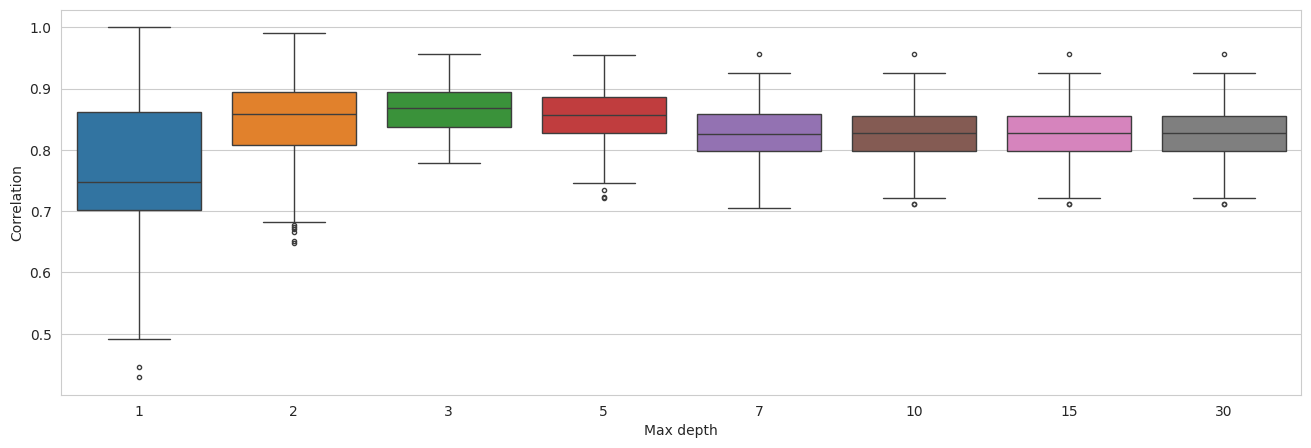

In [25]:
plt.figure(figsize=(16,5))
plt.axes(xlabel = 'Max depth', ylabel = 'Correlation', xticklabels = max_depth_list)

sns.boxplot(data=corr_max_depth_list);

Опишите ваши наблюдения:

* получилось не очень выраженно, но всё таки при увеличении числа признаков корреляция между предсказаниями растёт. Увеличивая количество отбираемых признаком, мы снижаем элемент случайности, что и делает предсказания более похожими
* При увеличении глубины эффект ещё менее заметен, но некоторое падение можно отметить. Увеличивая глубину, мы увеличиваем переобучаемость отдельных деревьев, следовательно, повышаем разброс предсказаний.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [27]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [28]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [29]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, verbosity=-1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [ ]:
voting_hard = VotingClassifier(estimators=base_models,
                               voting='hard')

voting_soft = VotingClassifier(estimators=base_models,
                               voting='soft')

# Отдельно список названий, просто для наглядности
models_names = ['DT', 'RF', 'CAT', 'ETC', 'KNN', 'SVC_LIN', 'SVC_RBF',  'XGB', 'LGBM', 'XGB_RF', 'LGBM_RF', 'LR', 'NB', 'VH', 'VS']

# Добавил запись в список, иначе предупреждения LightGBM всё уносят
models_scores = []

for model, name in zip([dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft], models_names): 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    models_scores.append(f'{model.__class__.__name__} {name}: {scores.mean():.3g}')

In [31]:
models_scores

['DecisionTreeClassifier DT: 0.798',
 'RandomForestClassifier RF: 0.833',
 'CatBoostClassifier CAT: 0.834',
 'ExtraTreesClassifier ETC: 0.828',
 'KNeighborsClassifier KNN: 0.649',
 'SVC SVC_LIN: 0.84',
 'SVC SVC_RBF: 0.697',
 'XGBClassifier XGB: 0.813',
 'LGBMClassifier LGBM: 0.817',
 'XGBRFClassifier XGB_RF: 0.85',
 'LGBMClassifier LGBM_RF: 0.813',
 'LogisticRegression LR: 0.85',
 'GaussianNB NB: 0.814',
 'VotingClassifier VH: 0.849',
 'VotingClassifier VS: 0.846']

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [32]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

> **Мой коммент**

Нужно заново создать и обучить ансамбль, иначе после кросс-валидации не находится атрибут `estimators_`

In [ ]:
voting_hard = VotingClassifier(estimators=base_models,
                               voting='hard')

voting_hard.fit(X_train, y_train)

pred_voting_hard = voting_hard.predict(X_test)

corr_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

df_corr_hard = pd.DataFrame(corr_hard, columns=['Model_1', 'Model_2', 'Correlation'])

In [35]:
df_corr_hard.head(3)

,Model_1,Model_2,Correlation
0,"DecisionTreeClassifier(max_depth=10, min_sampl...","(DecisionTreeClassifier(max_features='sqrt', r...",0.868209
1,"DecisionTreeClassifier(max_depth=10, min_sampl...","(ExtraTreeClassifier(random_state=481767252), ...",0.802125
2,"DecisionTreeClassifier(max_depth=10, min_sampl...",KNeighborsClassifier(weights='distance'),0.802125


>**Мой коммент**

Очень хочется переименовать всё эту "красоту"

In [36]:
df_corr_hard.loc[:, 'Model_1'] = df_corr_hard.Model_1.apply(str)

df_corr_hard.loc[:, 'Model_2'] = df_corr_hard.Model_2.apply(str)

models_names_short = ['DT', 'RF', 'ETC', 'KNN', 'SVC_LIN', 'SVC_RBF', 'CAT', 'LGBM', 'LGBM_RF', 'XGB', 'XGB_RF', 'LR', 'NB']

models_names_df = df_corr_hard.Model_1.unique().tolist()
models_names_df.append('GaussianNB()')

In [37]:
for terrible_name, short_name in zip(models_names_df, models_names_short):
    df_corr_hard.replace(terrible_name, short_name, inplace=True)

In [38]:
# Продублирем таблицу, поменяв местами названия моделей и приклеим к первой таблице, чтобы красивая, симметричная картинка получилась без пропусков
df_corr_mirror = pd.DataFrame({'Model_1': df_corr_hard.Model_2, 
                               'Model_2':df_corr_hard.Model_1, 
                               'Correlation': df_corr_hard.Correlation})
df_corr = pd.concat([df_corr_hard, df_corr_mirror])
df_corr

,Model_1,Model_2,Correlation
0,DT,RF,0.868209
1,DT,ETC,0.802125
2,DT,KNN,0.802125
3,DT,SVC_LIN,0.831921
4,DT,SVC_RBF,0.540843
...,...,...,...
73,LR,XGB,0.784982
74,NB,XGB,0.738163
75,LR,XGB_RF,0.898810
76,NB,XGB_RF,0.834417


>**Мой коммент**

Надеюсь, нигде не перепутал названия

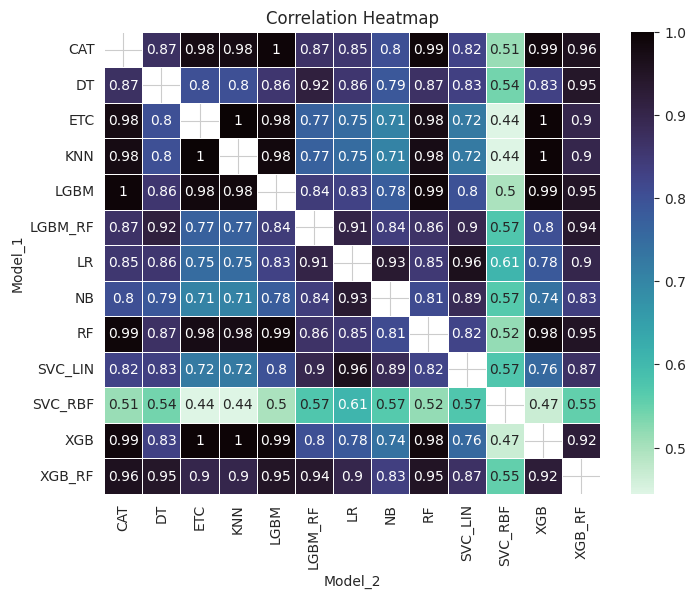

In [39]:
heatmap_data = df_corr.pivot(index='Model_1', columns='Model_2', values='Correlation')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='mako_r', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show();

In [40]:
models_set_main = [("DT", dt), 
               ("SVC_RBF", svc_rbf), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr),
               ("XGB_RF", xgb_rf)]

In [41]:
voting_hard = VotingClassifier(estimators=models_set_main,
                               voting='hard')
voting_soft= VotingClassifier(estimators=models_set_main,
                               voting='soft')

models_scores = []

for model, name in zip([voting_hard, voting_soft], ['V_hard', 'V_soft']): 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    models_scores.append(f'{name}: {scores.mean():.4g}')

In [42]:
models_scores

['V_hard: 0.8703', 'V_soft: 0.8523']

> Мой коммент

Набор моделей для этого скора был 8 попыткой простого подбора вручную. Потом было ещё несколько часов попыток ещё повысить скор, но не получилось 

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [4]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
data.iloc[:5, 10:11]

,Eve Mins
0,197.4
1,195.5
2,121.2
3,61.9
4,148.3


In [6]:
data.isna().sum().sum()

0

Пропусков нет, хорошо

In [7]:
data['Phone'].value_counts()

Phone
382-4657    1
348-7071    1
389-6082    1
415-3689    1
379-2503    1
           ..
352-1127    1
368-1288    1
403-5279    1
397-9333    1
400-4344    1
Name: count, Length: 3333, dtype: int64

Номер телефона выбрасываем

In [8]:
data.pop('Phone');

И уберём пробелы с апосторфом в названиях столбцов

In [9]:
new_col_names = ['State', 'Account_Length', 'Area_Code', 'Int_Plan',
       'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_ Calls', 'Day_Charge',
       'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls',
       'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge',
       'CustServ_Calls', 'Churn']

data.columns = new_col_names

In [10]:
print(data.shape)
data.dtypes

(3333, 20)


State              object
Account_Length      int64
Area_Code           int64
Int_Plan           object
VMail_Plan         object
VMail_Message       int64
Day_Mins          float64
Day_ Calls          int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
Intl_Calls          int64
Intl_Charge       float64
CustServ_Calls      int64
Churn              object
dtype: object

Переименуем лейблы и посмотрим на них

In [11]:
data.loc[data['Churn'] == 'False.','Churn'] = 0

data.loc[data['Churn'] == 'True.','Churn'] = 1

In [12]:
data['Churn'].value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

Баланс не очень, возможно, будет смещение предсказаний в сторону "0".

In [13]:
for i in ['State', 'Int_Plan', 'VMail_Plan']:
    print(data[i].value_counts().shape)

(51,)
(2,)
(2,)


'Int_Plan', 'VMail_Plan' - бинарные категории "yes/no", лишних значений нет.

Штатов 51, любопытно, конечно, но нам важнее, как распределена целевая величина для этого признака. Посчитаем долю "1" для каждого штата.

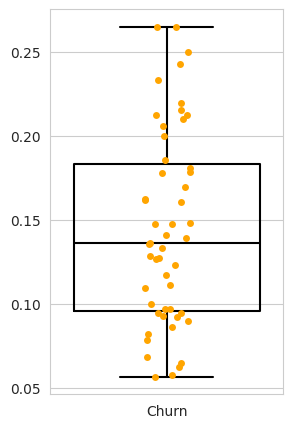

In [14]:
plt.figure(figsize=(3, 5))

sns.boxplot(data[['State', 'Churn']].groupby('State').agg('mean'), color='black', fill=False)
sns.stripplot(data[['State', 'Churn']].groupby('State').agg('mean'), color='orange');

Довольно равномерное распределение. Очевидно, есть какие-то штаты, в которых доля уходящих клиентов как значительно выше, так и значительно ниже среднего. Вероятно, этот признак может оказаться полезным.

In [15]:
data[['Int_Plan', 'VMail_Plan', 'Churn']].groupby('Churn').agg({'Int_Plan': 'value_counts',
                                                                'VMail_Plan': 'value_counts'})

Int_Plan  VMail_Plan
Churn                          
0     no       2664        2008
      yes       186         842
1     no        346         403
      yes       137          80

In [16]:
cat_cols = ['State', 'Int_Plan', 'VMail_Plan', 'Churn']

In [17]:
data.drop(cat_cols, axis=1).describe()

,Account_Length,Area_Code,VMail_Message,Day_Mins,Day_ Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


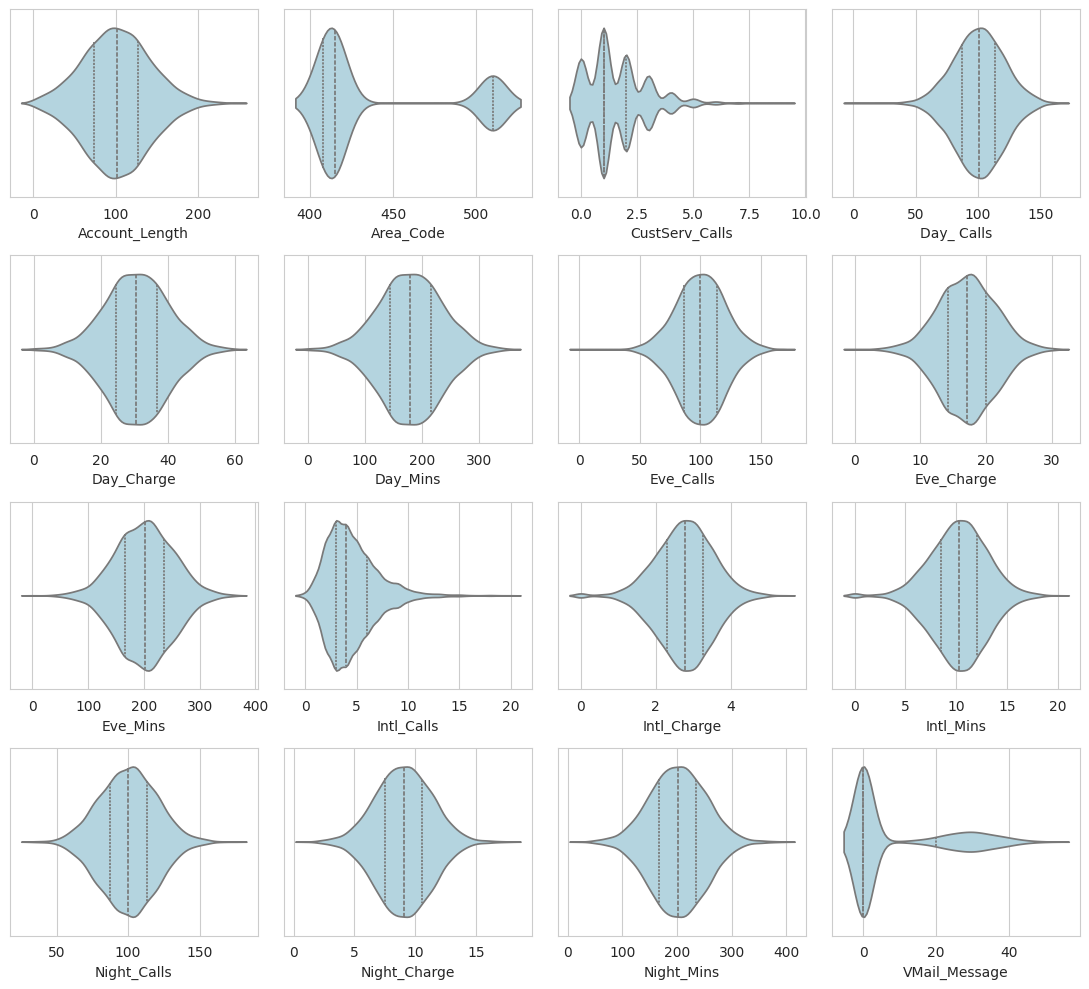

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(11, 10))

num_cols = data.columns.difference(cat_cols)

for i in range(data[num_cols].columns.size):
    feature = data[num_cols].columns[i]
    sns.violinplot(x=data[feature], ax=axes[i//4, i%4], inner="quartile", color='lightblue')

plt.tight_layout()
plt.show();

Распределения, в основном, хорошие. Очевидно, что много переменных типа 'calls' с дискретными данными, наиболее это заметно для 'CustServ_Calls'.

И очень подозрительно выглядят 'Area_Code' и 'VMail_Message'.

In [19]:
data.Area_Code.value_counts()

Area_Code
415    1655
510     840
408     838
Name: count, dtype: int64

In [20]:
data[['Area_Code', 'Churn']].groupby('Churn').agg('value_counts')

Churn  Area_Code
0      415          1419
       408           716
       510           715
1      415           236
       510           125
       408           122
Name: count, dtype: int64

In [21]:
print(data['VMail_Message'].value_counts().size)
data['VMail_Message'].value_counts()[:5]

46


VMail_Message
0     2411
31      60
29      53
28      51
33      46
Name: count, dtype: int64

In [22]:
data.loc[data['VMail_Message'] == 0, 'Churn'].value_counts()

Churn
0    2008
1     403
Name: count, dtype: int64

In [23]:
data.loc[data['VMail_Message'] > 0, 'Churn'].value_counts()

Churn
0    842
1     80
Name: count, dtype: int64

In [24]:
cat_cols.extend(['VMail_Message', 'Area_Code'])

num_cols = data.columns.difference(cat_cols)

Данные можно однозначно относить к категориальным.

Теперь оценим корреляцию.

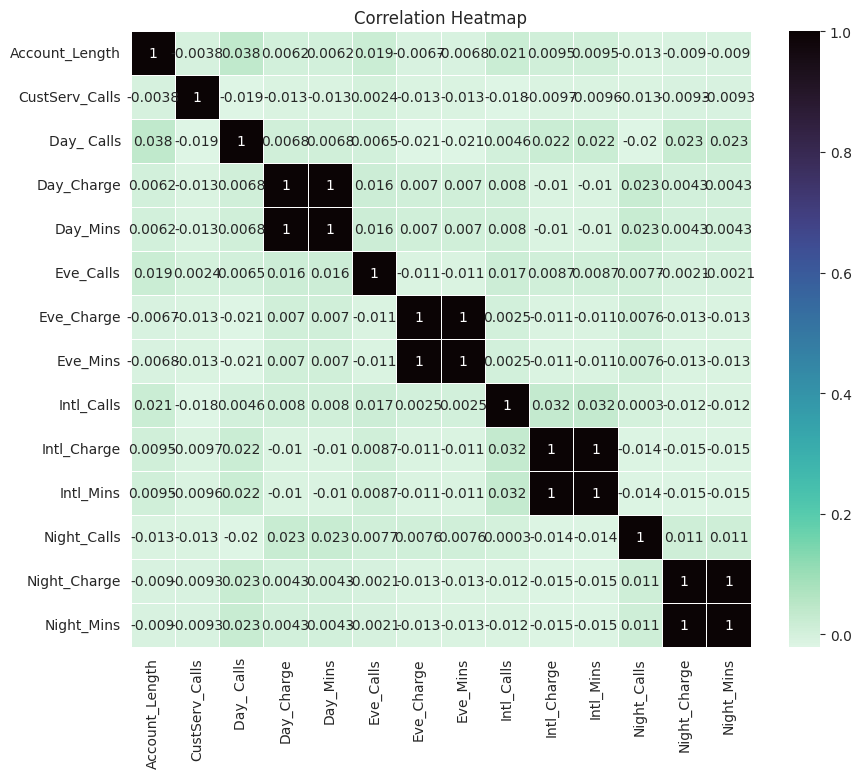

In [25]:
corr_mtx = data[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mtx, annot=True, cmap='mako_r', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show();

Конечно же: оплата точно пропроциональна числу минут. Есть смысл убрать один из наборов: либо 'Charge', либо 'Mins'.

Попробуем оставить минуты. И в качестве модели выберем Catboost.

In [26]:
cat_cols.pop(cat_cols.index('Churn'))
y = data.pop('Churn')
y = y.astype('int64')

In [27]:
Xm = data.loc[:, ~data.columns.isin(['Day_Charge', 'Eve_Charge', 'Night_Charge', 'Intl_Charge'])]

In [28]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [29]:
catcl_m = catboost.CatBoostClassifier()

In [ ]:
catcl_m.fit(Xm_train, ym_train, cat_features=cat_cols)

In [32]:
ym_pred = catcl_m.predict(Xm_test)

In [33]:
ym_pred_proba = catcl_m.predict_proba(Xm_test)

In [34]:
accuracy_score(ym_test, ym_pred)

0.949

In [35]:
roc_auc_score(ym_test, ym_pred_proba[: , 1])

0.8917428314302462

Можно для интереса сравнить, что было бы для другого набора скоррелированных столбцов и для полного датасета.

Оставляем 'Charge'

In [36]:
Xc = data.loc[:, ~data.columns.isin(['Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins'])]

In [37]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [38]:
catcl_c = catboost.CatBoostClassifier()

In [ ]:
catcl_c.fit(Xc_train, yc_train, cat_features=cat_cols)

In [40]:
yc_pred = catcl_c.predict(Xc_test)

In [41]:
yc_pred_proba = catcl_c.predict_proba(Xc_test)

In [42]:
accuracy_score(yc_test, yc_pred)

0.951

In [43]:
roc_auc_score(yc_test, yc_pred_proba[: , 1])

0.8961599749007175

Полный датасет, оставляем все данные

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [54]:
catcl = catboost.CatBoostClassifier()

In [ ]:
catcl.fit(X_train, y_train, cat_features=cat_cols)

In [56]:
y_pred = catcl.predict(X_test)

In [57]:
y_pred_proba = catcl.predict_proba(X_test)

In [58]:
accuracy_score(y_test, y_pred)

0.95

In [59]:
roc_auc_score(y_test, y_pred_proba[: , 1])

0.8942362469967552

Скор немного различается, интересно, что 'Mins' получился чуть хуже остальных. Но, конечно, надо делать больше проверок. В данном случае, критического влияния даже полностью скоррелированные данные не оказывают.

Попробуем теперь случайный лес, например, xgboost.XGBRFClassifier. Если Catboost сам справлялся, то здесь латегориальные данные надо предобработать.

У 'State' очень много значений, сложно будет кодировать. Попробуем просто убрать.

In [60]:
data_rf = pd.get_dummies(data, columns=['Int_Plan', 'VMail_Plan'], drop_first=True)

In [61]:
data_rf.pop('State');

In [62]:
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(data_rf, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

In [63]:
xgbrf = xgboost.XGBRFClassifier()

In [64]:
xgbrf.fit(Xrf_train, yrf_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, reg_alpha=None, ...)

In [65]:
yrf_pred = xgbrf.predict(Xrf_test)

In [66]:
yrf_pred_proba = xgbrf.predict_proba(Xrf_test)

In [67]:
accuracy_score(yrf_test, yrf_pred)

0.934

In [68]:
roc_auc_score(yrf_test, yrf_pred_proba[: , 1])

0.8830819276909486

Получилось хуже, чем у Catboost, но для справделивости сравним и его без 'State'

In [ ]:
data_x = data.copy()
data_x.pop('State')
cat_cols.pop(cat_cols.index('State'));

In [75]:
Xx_train, Xx_test, yx_train, yx_test = train_test_split(data_x, 
                                                        y, 
                                                        test_size=0.3,
                                                        random_state=SEED)

In [76]:
catcl_x = catboost.CatBoostClassifier()

In [ ]:
catcl_x.fit(Xx_train, yx_train, cat_features=cat_cols)

In [78]:
yx_pred = catcl_x.predict(Xx_test)

In [79]:
yx_pred_proba = catcl_x.predict_proba(Xx_test)

In [80]:
accuracy_score(yx_test, yx_pred)

0.952

In [81]:
roc_auc_score(yx_test, yx_pred_proba[: , 1])

0.895326084264236

Всё равно лучше, чем XGBRF, и на том же уровне, что и другие предсказая Catboost. Скорее всего, 'State' в принципе не сильно влияет.

Всё, что успел.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

Вот такой я мастер пэйнта

<img src="../Black Hole.bmp" alt="Pain rule!" width="900"/>

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Жутко большая домашка. Очень много времени всё ещё уходит на правильную работу с пандас, с визуализацией. На собственно МЛ, наверное, меньше трети времени. Как всегда: картинки, шаблоны и комментарии вноутбуке нравятся.

Играться с моделями в ансамбле было интересно и увлекательно. Жаль, что не хватило времени на последний раздел, но вдумчиво пнять, что зановые модели, и тем более вчитываться в параметры действительно уже никак не успевал.